In [1]:
from __future__ import division, print_function, absolute_import
from sklearn.linear_model import LogisticRegression
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def l2_logistic_regression(train_data, test_data, train_labels, test_labels):
    
    # Train model
    model = LogisticRegression(penalty='l2', random_state=42)
    model.fit(train_data, train_labels)    
    
    # Test model
    y_train_pred = model.predict(train_data)
    y_test_pred = model.predict(test_data)

    # Evaluate model
    print('Logistic Regression - \nTrain Accuracy: ', round(np.sum(y_train_pred == train_labels) / train_data.shape[0], 4))
    print('Test Accuracy: ', round(np.sum(y_test_pred == test_labels) / test_data.shape[0], 4))

In [3]:
def knn(k, distance_matrix, train_labels, test_labels):

    predicted_labels = []       # List of predicted labels for test set 
    for i in range(distance_matrix.shape[0]):
          
        # Store indices of sorted neighbors
        neighbors = np.argsort(distance_matrix[i])
            
        # Store labels of k nearest neighbors
        k_nearest_labels = []   
        for j in range(k):
            k_nearest_labels.append(train_labels[neighbors[j]])

        # Store value of the max no. of k_nearest_labels
        predicted_labels.append(max(k_nearest_labels, key=k_nearest_labels.count))

    # Print accuracy
    print('k=%d:' % (k), str(round(accuracy_score(test_labels, np.asarray(predicted_labels)) * 100, 2)), '%')

In [4]:
def find_k_nearest_neighbors(idx, k, distance_matrix, train_labels, test_labels):

    # Store indices of sorted neighbors
    neighbors = np.argsort(distance_matrix[idx])

    # Store labels of k nearest neighbors
    k_nearest_labels = []   
    for j in range(k):
        k_nearest_labels.append(train_labels[neighbors[j]])

    # Store value of the max no. of k_nearest_labels
    predicted_label = max(k_nearest_labels, key=k_nearest_labels.count)

    print('Indices of neighbors')
    print(neighbors[:k])
    print('Labels of neighbors')
    print(k_nearest_labels)
    print('Predicted Label')
    print(predicted_label)
    print('Correct Label')
    print(test_labels[idx], '\n')

In [5]:
def knn_classification(y_train, y_test, original_distance_matrix, encoder_distance_matrix, decoder_distance_matrix):
    
    K = 5
    k_nearest_neighbors = 10
    
    # Classification on original data
    print('kNN on Original Image')
    knn(K, original_distance_matrix, y_train, y_test)

    # Classification on encoder data
    print('kNN on Encoder Image')
    knn(K, encoder_distance_matrix, y_train, y_test)

    # Classification on reconstructed data
    print('kNN on Decoder Image')
    knn(K, decoder_distance_matrix, y_train, y_test)

    for idx in [0, 400, 800, 1200, 1600, 1950]:
        print('k-Nearest Neighbors of Original Image')
        find_k_nearest_neighbors(idx, k_nearest_neighbors, original_distance_matrix, y_train, y_test)
        print('k-Nearest Neighbors of Encoder Image')
        find_k_nearest_neighbors(idx, k_nearest_neighbors, encoder_distance_matrix, y_train, y_test)
        print('k-Nearest Neighbors of Decoder Image')
        find_k_nearest_neighbors(idx, k_nearest_neighbors, decoder_distance_matrix, y_train, y_test)
        print('--------------------')

In [ ]:
# Fetch data
fashion_train_path = abspath('datasets', 'fashion-mnist_train.csv')
fashion_test_path = abspath('datasets', 'fashion-mnist_test.csv')

fashion_train_dataset = np.loadtxt(open(fashion_train_path, 'rb'), delimiter=',', skiprows=1)
fashion_test_dataset = np.loadtxt(open(fashion_test_path, 'rb'), delimiter=',', skiprows=1)

print(fashion_train_dataset.shape)
print(fashion_test_dataset.shape)

In [ ]:
# Data and labels
fashion_train_data = fashion_train_dataset[:, list(range(1, fashion_train_dataset.shape[1]))]
fashion_train_labels = fashion_train_dataset[:, 0]
fashion_test_data = fashion_test_dataset[:, list(range(1, fashion_test_dataset.shape[1]))]
fashion_test_labels = fashion_test_dataset[:, 0]

print(fashion_train_data.shape)
print(fashion_train_labels.shape)
print(fashion_test_data.shape)
print(fashion_test_labels.shape)

In [ ]:
# Normalize data
norm_fashion_train_data = np.divide(fashion_train_data, 255)
norm_fashion_test_data = np.divide(fashion_test_data, 255)

In [ ]:
X_train = norm_fashion_train_data
X_test = norm_fashion_test_data
y_train = fashion_train_labels
y_test = fashion_test_labels

In [7]:
# Training Parameters
learning_rate = 0.01
num_steps = 15000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [8]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [9]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

train_data_batches = [X_train[i:i + batch_size] for i in range(0, len(X_train), batch_size)]
train_labels_batches = [y_train[i:i + batch_size] for i in range(0, len(y_train), batch_size)]

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = [train_data_batches[i % len(train_data_batches)], train_labels_batches[i % len(train_labels_batches)]]

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.370596
Step 1000: Minibatch Loss: 0.119196
Step 2000: Minibatch Loss: 0.103933
Step 3000: Minibatch Loss: 0.099920
Step 4000: Minibatch Loss: 0.094783
Step 5000: Minibatch Loss: 0.096513
Step 6000: Minibatch Loss: 0.093723
Step 7000: Minibatch Loss: 0.088938
Step 8000: Minibatch Loss: 0.087943
Step 9000: Minibatch Loss: 0.084783
Step 10000: Minibatch Loss: 0.085702
Step 11000: Minibatch Loss: 0.082105
Step 12000: Minibatch Loss: 0.080818
Step 13000: Minibatch Loss: 0.081395
Step 14000: Minibatch Loss: 0.077063
Step 15000: Minibatch Loss: 0.076751


Original Images


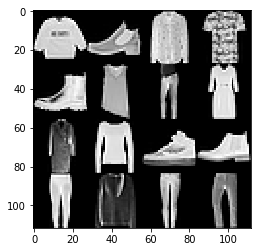

Reconstructed Images


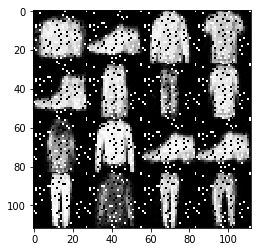

In [10]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))

train_data_batches = [X_train[i:i + batch_size] for i in range(0, len(X_train), batch_size)]
train_labels_batches = [y_train[i:i + batch_size] for i in range(0, len(y_train), batch_size)]

for i in range(n):
    # MNIST test set
    batch_x, _ = [train_data_batches[i % len(train_data_batches)], train_labels_batches[i % len(train_labels_batches)]]
    # Encode and decode the digit image
    g = sess.run(decoder_op, feed_dict={X: batch_x})
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

In [11]:
# Classification on original data
l2_logistic_regression(X_train, X_test, y_train, y_test)

Logistic Regression - 
Train Accuracy:  0.8722
Test Accuracy:  0.855


In [12]:
# Classification on encoder data
encoder_X_train = sess.run(encoder_op, feed_dict={X: X_train})
encoder_X_test = sess.run(encoder_op, feed_dict={X: X_test})
l2_logistic_regression(encoder_X_train, encoder_X_test, y_train, y_test)

Logistic Regression - 
Train Accuracy:  0.7728
Test Accuracy:  0.7786


In [13]:
# Classification on decoder data
decoder_X_train = sess.run(decoder_op, feed_dict={X: X_train})
decoder_X_test = sess.run(decoder_op, feed_dict={X: X_test})
l2_logistic_regression(decoder_X_train, decoder_X_test, y_train, y_test)

Logistic Regression - 
Train Accuracy:  0.8027
Test Accuracy:  0.8001


In [ ]:
original_cosine_distance_matrix = cosine_distances(X_test, X_train)
encoder_cosine_distance_matrix = cosine_distances(encoder_X_test, encoder_X_train)
decoder_cosine_distance_matrix = cosine_distances(decoder_X_test, decoder_X_train)
original_euclidean_distance_matrix = euclidean_distances(X_test, X_train)
encoder_euclidean_distance_matrix = euclidean_distances(encoder_X_test, encoder_X_train)
decoder_euclidean_distance_matrix = euclidean_distances(decoder_X_test, decoder_X_train)

In [ ]:
print('-------------------------------------------------')
print('Using Euclidean distances ....')
print('-------------------------------------------------')
knn_classification(y_train, y_test, original_cosine_distance_matrix, encoder_cosine_distance_matrix, decoder_cosine_distance_matrix)

In [ ]:
print('-------------------------------------------------')
print('Using Cosine distances ....')
print('-------------------------------------------------')
knn_classification(y_train, y_test, original_euclidean_distance_matrix, encoder_euclidean_distance_matrix, decoder_euclidean_distance_matrix)

In [14]:
sampled_X_train = []
sampled_y_train = []
sampled_encoder_X_train = []
sampled_decoder_X_train = []

for i in range(len(X_train)):
    if i % 5 == 0:
        sampled_X_train.append(X_train[i])
        sampled_y_train.append(y_train[i])
        sampled_encoder_X_train.append(encoder_X_train[i])
        sampled_decoder_X_train.append(decoder_X_train[i])
        
sampled_X_test = []
sampled_y_test = []
sampled_encoder_X_test = []
sampled_decoder_X_test = []
for i in range(len(X_test)):
    if i % 5 == 0:
        sampled_X_test.append(X_test[i])
        sampled_y_test.append(y_test[i])
        sampled_encoder_X_test.append(encoder_X_test[i])
        sampled_decoder_X_test.append(decoder_X_test[i])

sampled_X_train = np.array(sampled_X_train)
sampled_X_test = np.array(sampled_X_test)
sampled_y_train = np.array(sampled_y_train)  #np.argmax(np.array(sampled_y_train), axis=1)
sampled_y_test = np.array(sampled_y_test) #np.argmax(np.array(sampled_y_test), axis=1)
sampled_encoder_X_train = np.array(sampled_encoder_X_train)
sampled_encoder_X_test = np.array(sampled_encoder_X_test)
sampled_decoder_X_train = np.array(sampled_decoder_X_train)
sampled_decoder_X_test = np.array(sampled_decoder_X_test)

original_cosine_distance_matrix = cosine_distances(sampled_X_test, sampled_X_train)
encoder_cosine_distance_matrix = cosine_distances(sampled_encoder_X_test, sampled_encoder_X_train)
decoder_cosine_distance_matrix = cosine_distances(sampled_decoder_X_test, sampled_decoder_X_train)
original_euclidean_distance_matrix = euclidean_distances(sampled_X_test, sampled_X_train)
encoder_euclidean_distance_matrix = euclidean_distances(sampled_encoder_X_test, sampled_encoder_X_train)
decoder_euclidean_distance_matrix = euclidean_distances(sampled_decoder_X_test, sampled_decoder_X_train)

In [15]:
print(original_euclidean_distance_matrix)
print(encoder_euclidean_distance_matrix)
print(decoder_euclidean_distance_matrix)

[[11.1185994  10.13138906  6.33269104 ... 13.98722546  5.75871771
  13.15269915]
 [11.06681119  8.35825478 11.4023531  ...  8.32133762 11.38796859
  11.86584111]
 [12.77382645 10.58351601  8.29060696 ... 12.86026459  8.641897
  13.10502045]
 ...
 [13.28754074 10.06310424 11.01907053 ...  6.45918425 10.89538877
  12.78161165]
 [14.36818434 12.04793834 16.38499703 ...  6.41924251 15.8957663
  12.9051918 ]
 [11.97972913  9.26739768  8.1460543  ...  9.48779422  9.25335896
  12.3375416 ]]
[[2.0181103  2.6721177  1.459583   ... 3.3374226  0.45541748 2.7739327 ]
 [2.1771054  2.5515864  2.2037551  ... 2.5778654  2.2039256  2.670139  ]
 [2.9286742  2.9926553  2.2136474  ... 3.5229957  2.467365   3.220199  ]
 ...
 [3.2681963  3.186862   2.725634   ... 2.3102834  2.9136357  3.4114156 ]
 [3.3089962  3.5429764  3.841644   ... 2.7863805  3.6060338  3.25207   ]
 [2.6757798  2.956844   1.4279455  ... 2.9479187  2.1325173  3.266536  ]]
[[ 8.947475   8.752976   3.8455756 ... 12.730522   0.5566646 11.641

In [16]:
knn_classification(sampled_y_train, sampled_y_test, original_cosine_distance_matrix, encoder_cosine_distance_matrix, decoder_cosine_distance_matrix)

kNN on Original Image
k=5: 81.95 %
kNN on Encoder Image
k=5: 77.65 %
kNN on Decoder Image
k=5: 78.0 %
k-Nearest Neighbors of Original Image
Indices of neighbors
[11477   274  3482  2512  4780  9091  8092  1973  6385  4479]
Labels of neighbors
[0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 6.0, 0.0, 0.0, 6.0]
Predicted Label
0.0
Correct Label
0.0 

k-Nearest Neighbors of Encoder Image
Indices of neighbors
[ 9091  3586  4780  9718 11477  9745 11998  6440  4677   443]
Labels of neighbors
[0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 6.0, 6.0, 0.0]
Predicted Label
0.0
Correct Label
0.0 

k-Nearest Neighbors of Decoder Image
Indices of neighbors
[11998  6440 11520 11477  9091  4780  6016  2512  3586  4479]
Labels of neighbors
[0.0, 6.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 6.0]
Predicted Label
0.0
Correct Label
0.0 

--------------------
k-Nearest Neighbors of Original Image
Indices of neighbors
[ 7818  8466  5693  9610  6830 11825  6996  1561  1620   952]
Labels of neighbors
[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8

In [17]:
knn_classification(sampled_y_train, sampled_y_test, original_euclidean_distance_matrix, encoder_euclidean_distance_matrix, decoder_euclidean_distance_matrix)

kNN on Original Image
k=5: 82.6 %
kNN on Encoder Image
k=5: 77.5 %
kNN on Decoder Image
k=5: 77.95 %
k-Nearest Neighbors of Original Image
Indices of neighbors
[  274  4780 11477  1973  8092  6385 10941  9962 10096  2512]
Labels of neighbors
[0.0, 6.0, 0.0, 0.0, 6.0, 0.0, 6.0, 0.0, 6.0, 0.0]
Predicted Label
0.0
Correct Label
0.0 

k-Nearest Neighbors of Encoder Image
Indices of neighbors
[ 9091  3586  4780  9718 11477  9745 11998  6440  4677   443]
Labels of neighbors
[0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 6.0, 6.0, 0.0]
Predicted Label
0.0
Correct Label
0.0 

k-Nearest Neighbors of Decoder Image
Indices of neighbors
[11998  6440 11520 11477  9091  4780  6016  2512  3586  9962]
Labels of neighbors
[0.0, 6.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0]
Predicted Label
0.0
Correct Label
0.0 

--------------------
k-Nearest Neighbors of Original Image
Indices of neighbors
[9610 1561 5693 8466 9139 9794 1231 4825 3564 1620]
Labels of neighbors
[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
Pr